# Tutorial 2: Integrating adjacent DLPFC slices

This tutorial demonstrates SMILE's ablility to integrate two adjacent slices (151674 and 151675). The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://figshare.com/articles/dataset/DLPFC_slices_and_reference_scRNA-seq_data/27987548

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from stSMILE import SMILE

In [3]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squidpy as sq
import scipy.sparse as sp
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from itertools import chain
from scanpy import read_10x_h5
import torch.optim as optim
import sklearn
from sklearn.neighbors import kneighbors_graph
import gudhi
import networkx as nx
from torch_geometric.nn import GCNConv
import random
import os
import json 
import matplotlib.image as mpimg

In [4]:
#os.chdir('/Users/lihuazhang/Documents/SMILE-main/results')

# load data

In [5]:
section_ids = ['151674','151675']
print(section_ids)

['151674', '151675']


In [6]:
def label_to_int(adataA, label_list, label_name):
    adata_label = np.array(adataA.obs[label_name].copy())
    for i in range(len(label_list)):
        need_index = np.where(adataA.obs[label_name]==label_list[i])[0]
        if len(need_index):
            adata_label[need_index] = i
    adataA.obs['ref'] = adata_label
    return adataA

In [7]:
adata_l = []
for i in range(len(section_ids)):
    adata_i = sc.read_h5ad('/Users/lihuazhang/Documents/SMILE-main/dataset/DLPFC/DLPFC_'+ section_ids[i]+'_ST_final.h5ad')
    adata_i.obs_names = [x+'_'+section_ids[i] for x in adata_i.obs_names]
    adata_l.append(adata_i)

In [8]:
# convert label to int
label_list = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']

In [9]:
for i in range(len(section_ids)):
    adata_l[i] = label_to_int(adata_l[i], label_list, 'Ground Truth')

In [10]:
adata0_sc = sc.read_h5ad('/Users/lihuazhang/Documents/SMILE-main/dataset/DLPFC/DLPFC_sc_final.h5ad') 

In [11]:
adata0_sc

AnnData object with n_obs × n_vars = 19764 × 3010
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'cell_subtype', 'subject', 'condition', 'batch', 'n_genes', 'ref'
    var: 'features', 'n_cells', 'n_counts'
    uns: 'rank_genes_groups'
    obsm: 'X_pca'
    obsp: 'adj_f'

In [12]:
label0_list = adata0_sc.obs['cell_subtype'].tolist()
adata0_label_new = adata0_sc.obs['cell_subtype'].tolist()
for i in range(len(label0_list)):
    need_index = np.where(adata0_sc.obs['cell_subtype'] == label0_list[i])[0]    
    if len(need_index):
        for p in range(len(need_index)):
            adata0_label_new[need_index[p]] = i  

In [13]:
adata0_sc.obs['ref'] = pd.Series(adata0_label_new, index = adata0_sc.obs['cell_subtype'].index)
adata0_sc.obs['ref'] = adata0_sc.obs['ref'].astype(str)
adata0_sc.obs['ref'] = adata0_sc.obs['ref'].astype('category')
adata0_sc.obs['Ground Truth'] = adata0_sc.obs['cell_subtype']

In [14]:
adata_l.append(adata0_sc)

In [15]:
len(adata_l)

3

# Run SMILE

In [16]:
in_features = len(adata_l[0].var.index)
hidden_features = 512
out_features = 50

In [17]:
tag_l = ['ST','ST','single cell']

In [18]:
feature_method = 'GCNConv'
alpha = 0.001
beta = 1 
lamb = 0.01 
theta = 0.001 
gamma = 10 # reconstruct 
spatial_regularization_strength= 0.9
lr=1e-3
subepochs=100
epochs=200
max_patience=50
min_stop=20
random_seed=2024
gpu=0
regularization_acceleration=True
edge_subset_sz=1000000

In [19]:
add_topology = True
add_feature = False
add_image = False
add_sc = True

In [20]:
multiscale = True

In [21]:
anchor_type = None
anchors_all = False
use_rep_anchor = 'embedding'
align_method = 'MMD'
anchor_size=8000

In [22]:
iter_comb= None
n_clusters_l = [7]
edge_weights = [1,0.1,0.1]
class_rep = 'reconstruct'

In [23]:
adata_l = SMILE(adata_l, tag_l, section_ids, multiscale,  n_clusters_l, in_features, feature_method, hidden_features, out_features, iter_comb, anchors_all, use_rep_anchor, alpha, beta, lamb, theta, gamma,edge_weights, add_topology, add_feature, add_image, add_sc, spatial_regularization_strength, lr=lr, subepochs=subepochs, epochs=epochs, class_rep = class_rep)

Pretraining to extract embeddings of spots...
epoch   0: train spatial C loss: 0.0000, train F loss: 38.8459,
epoch  10: train spatial C loss: 0.0000, train F loss: 30.2219,
epoch  20: train spatial C loss: 0.0000, train F loss: 24.9213,
epoch  30: train spatial C loss: 0.0000, train F loss: 21.6007,
epoch  40: train spatial C loss: 0.0000, train F loss: 19.4514,
epoch  50: train spatial C loss: 0.0000, train F loss: 17.9709,
epoch  60: train spatial C loss: 0.0000, train F loss: 16.9083,
epoch  70: train spatial C loss: 0.0000, train F loss: 16.1047,
epoch  80: train spatial C loss: 0.0000, train F loss: 15.4772,
epoch  90: train spatial C loss: 0.0000, train F loss: 14.9738,
Training classifier...
Training classifier...
torch.Size([3635, 33])
torch.Size([3566, 33])
epoch   0: overall loss: 9.7800,sc classifier loss: 3.4852,representation loss: 0.6295,within spatial regularization loss: 0.1034
torch.Size([3635, 33])
torch.Size([3566, 33])
torch.Size([3635, 33])
torch.Size([3566, 33])


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Identifying anchors...
Processing datasets (0, 1)
0.8404312902226964
The ratio of filtered mnn pairs: 0.8344709043272199
Aligning by anchors...
epoch 100: total loss:14.5462, train F loss: 14.5352, train C loss: 1.9671, train D loss: 0.0110
epoch 110: total loss:14.1527, train F loss: 14.1463, train C loss: 0.2483, train D loss: 0.0064
epoch 120: total loss:13.8135, train F loss: 13.8097, train C loss: 0.1978, train D loss: 0.0038
epoch 130: total loss:13.4963, train F loss: 13.4930, train C loss: 0.1789, train D loss: 0.0033
epoch 140: total loss:13.2162, train F loss: 13.2132, train C loss: 0.1657, train D loss: 0.0030
epoch 150: total loss:12.9682, train F loss: 12.9651, train C loss: 0.1568, train D loss: 0.0031
epoch 160: total loss:12.7516, train F loss: 12.7484, train C loss: 0.1465, train D loss: 0.0032
epoch 170: total loss:12.5447, train F loss: 12.5414, train C loss: 0.1370, train D l

In [24]:
adata_concat_st = ad.concat(adata_l[0:len(section_ids)], label="slice_name", keys=section_ids)

In [25]:
sc.tl.pca(adata_concat_st)
adata_concat_st.obsm['X_pca_old'] = adata_concat_st.obsm['X_pca'].copy()
adata_concat_st.obsm['X_pca'] = adata_concat_st.obsm['embedding'].copy()
sc.pp.neighbors(adata_concat_st)  
sc.tl.umap(adata_concat_st)

In [26]:
sc.tl.leiden(adata_concat_st, random_state=666, key_added="leiden", resolution=0.18)
len(list(set(adata_concat_st.obs['leiden'].tolist())))

7

In [27]:
from stSMILE import analysis
analysis.mclust_R(adata_concat_st, num_cluster=7, used_obsm="embedding")

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 7201 × 3010
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'n_genes', 'image_cluster', 'dbscan_cluster_new', 'ref', 'pd_cluster', 'slice_name', 'leiden', 'mclust'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'features', 'features_summary_scale0.5_0.5', 'features_summary_scale0.5_1', 'features_summary_scale0.5_2', 'features_summary_scale1_0.5', 'features_summary_scale1_1', 'features_summary_scale1_2', 'features_summary_scale2_0.5', 'features_summary_scale2_1', 'features_summary_scale2_2', 'spatial', 'embedding', 'hidden_spatial', 'reconstruct', 'deconvolution', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

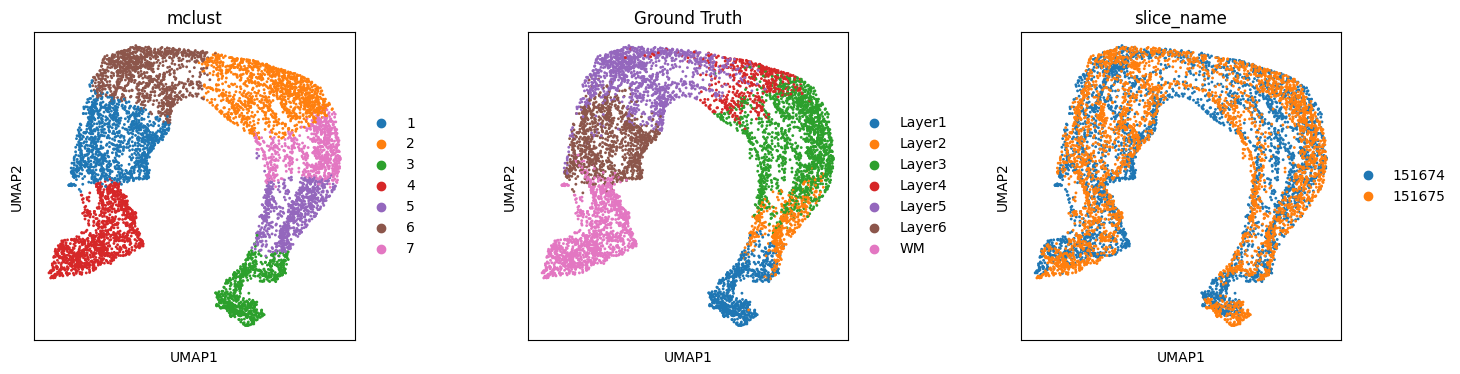

In [28]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_concat_st,color=["mclust",'Ground Truth',"slice_name"], wspace=0.4, save = 'DLPFC_umap_cluster_SMILE.pdf')  

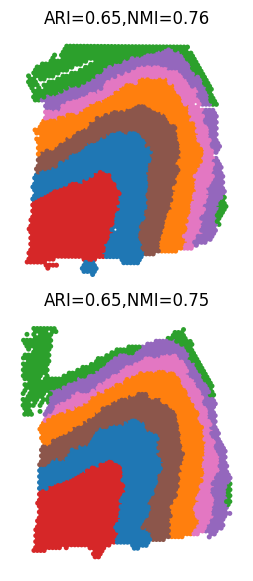

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
# split to each data
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat_st[adata_concat_st.obs['slice_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
NMI_list = []
for bb in range(len(section_ids)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))
    NMI_list.append(round(nmi_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(2, 1, figsize=(3.5, 7), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0])+",NMI=" + str(NMI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1])+",NMI=" + str(NMI_list[1]), size=title_size)
plt.savefig("DLPFC_spatial_SMILE.pdf") 
plt.show()

In [30]:
adata_l[0].uns['deconvolution']

,AAACAAGTATCTCCCA-1_151674_151674,AAACAATCTACTAGCA-1_151674_151674,AAACACCAATAACTGC-1_151674_151674,AAACAGAGCGACTCCT-1_151674_151674,AAACAGCTTTCAGAAG-1_151674_151674,AAACAGGGTCTATATT-1_151674_151674,AAACAGTGTTCCTGGG-1_151674_151674,AAACATTTCCCGGATT-1_151674_151674,AAACCCGAACGAAATC-1_151674_151674,AAACCGGGTAGGTACC-1_151674_151674,...,TTGTGTATGCCACCAA-1_151674_151674,TTGTGTTTCCCGAAAG-1_151674_151674,TTGTTAGCAAATTCGA-1_151674_151674,TTGTTCAGTGTGCTAC-1_151674_151674,TTGTTGTGTGTCAAGA-1_151674_151674,TTGTTTCACATCCAGG-1_151674_151674,TTGTTTCATTAGTCTA-1_151674_151674,TTGTTTCCATACAACT-1_151674_151674,TTGTTTGTATTACACG-1_151674_151674,TTGTTTGTGTAAATTC-1_151674_151674
Ex_3_L4_5,6.969129e-03,6.174900e-04,1.027352e-08,2.907331e-02,1.151733e-01,2.179292e-01,6.726495e-05,1.173180e-02,3.489990e-03,6.216561e-01,...,1.107924e-02,3.292672e-03,1.327825e-01,3.654320e-01,7.285582e-01,2.056747e-07,7.804774e-08,1.532008e-02,6.899436e-05,3.995313e-06
Mix_2,1.144664e-07,3.622714e-07,1.838581e-06,7.544602e-08,3.360677e-01,1.030835e-03,1.469804e-04,9.631843e-07,9.051941e-10,6.517683e-04,...,2.440290e-04,4.984937e-04,4.404069e-06,3.596538e-03,1.487128e-03,2.864074e-05,9.462240e-06,1.683173e-02,6.111187e-05,2.503635e-09
Astros_3,7.542109e-13,4.976497e-09,3.281698e-05,5.876007e-13,1.142282e-05,2.532608e-05,1.662139e-04,5.499309e-12,1.104752e-12,7.876854e-08,...,1.222819e-04,8.953258e-04,9.232067e-12,1.188053e-08,1.772218e-08,2.183260e-03,3.123484e-04,6.731632e-03,1.586484e-05,9.812313e-09
Inhib_5,2.599940e-05,3.712677e-06,4.739135e-07,2.806954e-06,1.215782e-05,2.259663e-07,1.252311e-05,1.007999e-03,2.926604e-09,2.613846e-09,...,3.426004e-07,2.554535e-06,1.385688e-04,9.882564e-07,2.053443e-07,3.610777e-06,2.119538e-06,4.931921e-05,3.495906e-06,5.199091e-08
Oligos_2,3.322113e-10,6.356483e-09,3.128458e-01,1.226389e-10,3.514589e-06,1.537011e-06,2.353112e-03,1.832942e-09,9.932827e-12,1.220030e-08,...,8.208621e-06,1.067566e-04,1.000387e-09,3.041905e-08,2.118467e-08,4.344048e-01,3.445954e-01,9.848450e-04,3.311624e-04,8.219440e-10
OPCs_1,2.303407e-08,6.548941e-07,1.453799e-05,1.375264e-08,5.889276e-06,3.458549e-05,1.181179e-04,1.105657e-08,2.375208e-06,9.104296e-07,...,2.467473e-04,1.040747e-03,6.711546e-09,7.872727e-07,2.454133e-06,1.097253e-03,6.136653e-05,3.437947e-03,2.492627e-05,2.216885e-03
Mix_5,7.022922e-02,2.340805e-05,2.529608e-05,5.073861e-02,4.253091e-03,1.422330e-04,1.955855e-04,3.317325e-02,1.347937e-03,3.805917e-05,...,3.302010e-05,1.225939e-04,1.175446e-03,1.850879e-02,2.356324e-02,1.551443e-04,6.335450e-05,7.949749e-04,6.539816e-05,3.841993e-05
Inhib_6_SST,3.809572e-05,7.408547e-11,4.430857e-07,1.531785e-05,1.065465e-05,4.851082e-08,8.072549e-07,2.037239e-05,5.269946e-08,2.654861e-09,...,7.926588e-09,5.665231e-08,2.914060e-05,1.695641e-02,1.828895e-02,4.030802e-06,1.114944e-06,2.130349e-06,2.774746e-08,8.693223e-10
Oligos_1,4.715230e-10,1.093477e-08,6.251897e-01,2.400796e-10,3.440437e-06,9.618647e-06,1.489260e-01,1.626619e-09,3.958604e-11,9.314818e-08,...,8.908093e-05,6.741536e-04,2.843505e-10,3.177034e-09,3.359012e-09,4.213376e-01,5.292145e-01,1.707045e-03,9.126685e-02,4.159424e-10
Mix_1,9.387812e-09,2.771037e-09,8.217115e-07,6.523106e-09,1.420885e-01,8.507208e-04,5.206808e-04,5.062454e-08,4.212891e-11,1.321318e-04,...,9.792802e-05,3.395937e-04,2.503545e-08,2.687180e-05,2.250277e-05,3.613956e-06,4.228411e-06,5.304500e-03,3.774091e-04,6.675904e-12


In [31]:
# write out the deconvolution result
for i in range(len(adata_l)-1):
    adata_i = adata_l[i].copy()
    dev_i = adata_i.uns['deconvolution']
    dev_i.to_csv('DLPFC_SMILE_dev_'+ section_ids[i]+'.csv', sep='\t')